<a href="https://colab.research.google.com/github/clionelove123/Machine_Learning/blob/main/ML_Chap_10_Genetic_Algorithm_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 코드 출처: https://github.com/Junst/TSP-Genetic-Algorithm/tree/master

import random
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

In [5]:
MUTATION_RATE = 40
MUTATION_COUNT = 2
THRESHOLD = 35000
UNIFORMCROSSOVER_RATE = 0.5

csvfile = '/content/TSP.csv'

In [6]:
def read_csv(csvf): #csv 파일 읽기, csv file read
    City = np.genfromtxt(open(csvf, "rb"),dtype=float, delimiter=",", skip_header=0)
    print(City)
    return City

cityCoordinates = read_csv(csvfile)
citySize = len(read_csv(csvfile))


[[53.25009344 22.44488521]
 [21.57092818 17.44707561]
 [72.16107676 85.88179689]
 ...
 [ 6.28095388 87.71359465]
 [81.30504684 27.76985517]
 [45.90940209 22.3171196 ]]
[[53.25009344 22.44488521]
 [21.57092818 17.44707561]
 [72.16107676 85.88179689]
 ...
 [ 6.28095388 87.71359465]
 [81.30504684 27.76985517]
 [45.90940209 22.3171196 ]]


In [7]:
class Genome():
    chromosomes = []
    fitness = 100000

    def __init__(self, numberOfchromosomes=None):
        if numberOfchromosomes is not None:
            self.chromosomes = list(range(numberOfchromosomes))
            randShuffle(self.chromosomes)


In [8]:
def randShuffle(listToShuffle):
    return random.shuffle(listToShuffle)


In [9]:
def init_population(size) :
    initial_population = []
    for i in range(size):
        newGenome = Genome()
        newGenome.chromosomes = random.sample(range(1, citySize), citySize - 1)
        newGenome.chromosomes.insert(0, 0)
        newGenome.chromosomes.append(0)
        newGenome.fitness = Evaluate(newGenome.chromosomes)
        initial_population.append(newGenome)
    return initial_population

In [10]:
def Evaluate(chromosomes):
    Fitness = 0
    for i in range(len(chromosomes) - 1):
        p1 = cityCoordinates[chromosomes[i]]
        p2 = cityCoordinates[chromosomes[i + 1]]
        Fitness += Euclidean_distance(p1, p2)
    Fitness = np.round(Fitness, 2)
    return Fitness

In [11]:
def Euclidean_distance(x, y):
#    dist=np.sum(np.abs(np.array(x)-np.array(y)))
    dist = np.linalg.norm(np.array(x)-np.array(y))
    return dist

In [12]:
def findBestGenome(population):
    allFitness = [i.fitness for i in population]
    bestFitness = min(allFitness)
    return population[allFitness.index(bestFitness)]

In [13]:
def TournamentSelection(population, k):
    select = [population[random.randrange(0, len(population))] for i in range(k)]
    bestGenome = findBestGenome(select)
    return bestGenome

In [14]:
def Reproduction(population):
    parent1 = TournamentSelection(population, 15).chromosomes
    parent2 = TournamentSelection(population, 15).chromosomes
    while parent1 == parent2:
        parent2 = TournamentSelection(population, 15).chromosomes

    return OrderCrossover(parent1, parent2)

def randRange(first,last):
    return random.randint(first,last)


In [15]:
def OrderCrossover(parent1, parent2):
    child = Genome(None)
    child.chromosomes = []
    firstIndex = randRange(0,len(parent1)-1)
    secondIndex = randRange(firstIndex, len(parent1)-1)
    innerSet = parent1[firstIndex:secondIndex]
    startSet = []
    endSet = []
    for _, value in enumerate([item for item in parent2 if item not in innerSet]):
        if len(startSet)<firstIndex:
            startSet.append(value)
        else:
            endSet.append(value)
    child.chromosomes = startSet + innerSet + endSet

    if random.randrange(0, 100) < MUTATION_RATE:
        child.chromosomes = InversionMutation(child.chromosomes)

    child.fitness = Evaluate(child.chromosomes)
    return child


In [16]:
def InversionMutation(chromo) :
    for x in range(MUTATION_COUNT):
        p1, p2 = [random.randrange(1, len(chromo) - 1) for i in range(2)]
        while p1 == p2 or p1 > p2:
            p1 = random.randint(0, len(chromo) - 1)
            p2 = random.randint(0, len(chromo) - 1)
        log = chromo[p1:p2]
        log = log[::-1]
        chromo = chromo[:p1] + log +chromo[p2:]
    return chromo

In [17]:
def fitness_plot(generation, allBestFitness):
    plt.plot(range(0, generation), allBestFitness, c='blue')
    plt.xlabel('Generations')
    plt.ylabel('Best Fitness')
    plt.title('Fitness Function')
    plt.show()

In [18]:
def city_visualize(bestGenome, city):
    start = None
    for x, y in city:
        if start is None: #시작지점이면 표시
            start = city[0]
            plt.scatter(start[0], start[1], c="green", marker=">")
            plt.annotate("Start", (x + 2, y - 2), color='red')
        else: #시작지점 아니면
            plt.scatter(x, y, marker='.', s=10, c="black")

    #edge 표현을 위한 x, y 범위
    x_edge = [city[i][0] for i in bestGenome.chromosomes]
    y_edge = [city[i][1] for i in bestGenome.chromosomes]

    plt.plot(x_edge, y_edge, color="blue", linewidth=0.07, linestyle="-")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('City Edges')
    plt.show()

In [19]:
def GeneticAlgorithm(populationSize, Generation_Count):
    allBestFitness = []
    population = init_population(populationSize)
    generation = 0
    TotalBestFitness = 100000
    TotalBestPath = []

    averageFitness = round(np.sum([genom.fitness for genom in population]) / len(population), 2)
    bestGenome = findBestGenome(population)
    TotalBestFitness = bestGenome.fitness
    TotalBestPath = bestGenome.chromosomes
    print("Init_Condition\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}".format(generation, len(population), averageFitness,bestGenome.fitness))
    print("Total Best Fitness : ",TotalBestFitness)
    print("Best Path:",TotalBestPath)
    allBestFitness.append(bestGenome.fitness)
    city_visualize(bestGenome, cityCoordinates)

    start = time.time()
    pre_turn=0;

    while generation < Generation_Count:
        generation += 1
        pre_turn += 1

        for i in range(populationSize):
            population.append(Reproduction(population))

        for genom in population:
            if genom.fitness > THRESHOLD:
                population.remove(genom)

        averageFitness = round(np.sum([genom.fitness for genom in population]) / len(population), 2)
        bestGenome = findBestGenome(population)
        end = time.time()

        if bestGenome.fitness < TotalBestFitness:
            TotalBestFitness = bestGenome.fitness
            TotalBestPath = bestGenome.chromosomes
            print("\n")
            print("Generation: {0}\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}".format(generation, len(population), averageFitness,bestGenome.fitness))
            print("Total Best Fitness : ",TotalBestFitness)
            print("Total time : ", end-start) # 소요 시간 표기, Working Time
            print("Best Path:",TotalBestPath)
            allBestFitness.append(bestGenome.fitness)
            if 99.9  < pre_turn:
              city_visualize(bestGenome, cityCoordinates)
              pre_turn=0

    TotalBestFitness = bestGenome.fitness
    TotalBestPath = bestGenome.chromosomes
    print("\n")
    print("=========================================================================================================================")
    print("Final Result")
    print("Generation: {0}\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}".format(generation, len(population), averageFitness,bestGenome.fitness))
    print("Total Best Fitness : ",TotalBestFitness)
    print("Total time : ", end-start) # 소요 시간 표기, Working Time
    print("Best Path:",TotalBestPath)
    allBestFitness.append(bestGenome.fitness)
    city_visualize(bestGenome, cityCoordinates)


    return bestGenome.chromosomes

Init_Condition
Population Size: 100	 Average Fitness: 52341.47
Best Fitness: 50888.94
Total Best Fitness :  50888.94
Best Path: [0, 749, 199, 740, 965, 218, 448, 293, 19, 309, 505, 689, 765, 383, 615, 515, 915, 398, 15, 254, 404, 8, 715, 139, 986, 914, 840, 997, 216, 134, 597, 831, 666, 813, 899, 91, 461, 957, 700, 450, 558, 896, 212, 908, 593, 626, 590, 479, 231, 529, 667, 636, 732, 175, 451, 290, 127, 265, 954, 219, 387, 148, 475, 918, 16, 407, 415, 527, 827, 373, 263, 771, 563, 872, 795, 155, 629, 942, 837, 345, 573, 782, 972, 129, 687, 727, 316, 94, 118, 452, 657, 691, 146, 821, 889, 984, 126, 429, 638, 796, 14, 362, 574, 281, 933, 625, 268, 42, 11, 571, 998, 395, 227, 257, 964, 22, 449, 595, 327, 170, 471, 764, 944, 705, 968, 483, 532, 882, 423, 572, 701, 835, 993, 956, 326, 834, 445, 154, 694, 299, 642, 686, 742, 324, 492, 255, 394, 760, 995, 382, 490, 330, 196, 881, 399, 54, 848, 926, 534, 431, 329, 136, 70, 568, 928, 793, 706, 690, 789, 337, 132, 202, 677, 710, 849, 485, 582, 3

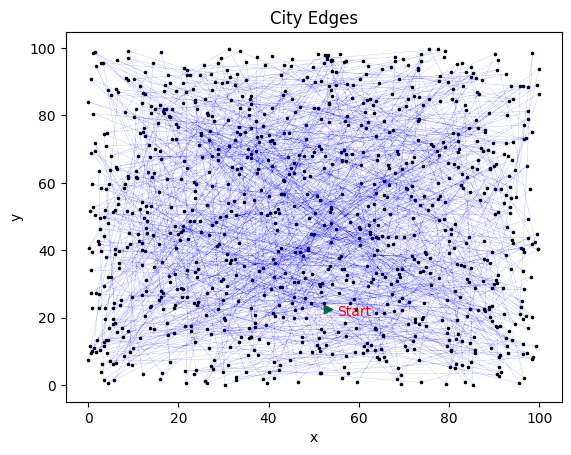



Generation: 1
Population Size: 100	 Average Fitness: 51345.13
Best Fitness: 49608.44
Total Best Fitness :  49608.44
Total time :  0.9046382904052734
Best Path: [0, 218, 293, 398, 15, 8, 986, 597, 899, 529, 918, 407, 739, 267, 191, 551, 956, 735, 49, 231, 12, 522, 419, 691, 577, 110, 779, 655, 503, 265, 131, 362, 990, 396, 391, 57, 371, 122, 897, 348, 786, 732, 222, 495, 636, 850, 262, 882, 958, 144, 620, 326, 235, 760, 637, 590, 189, 837, 214, 268, 965, 250, 910, 968, 173, 302, 774, 51, 824, 869, 263, 372, 810, 5, 885, 477, 717, 89, 982, 898, 813, 337, 651, 521, 854, 546, 116, 28, 312, 437, 608, 758, 759, 176, 729, 328, 61, 117, 817, 809, 722, 41, 96, 73, 775, 215, 17, 107, 761, 135, 102, 767, 296, 138, 342, 152, 32, 580, 481, 346, 841, 959, 766, 604, 569, 734, 205, 409, 752, 35, 823, 421, 2, 866, 48, 524, 603, 811, 193, 256, 653, 278, 876, 171, 947, 737, 80, 441, 724, 744, 960, 416, 838, 533, 291, 983, 272, 405, 611, 374, 978, 660, 424, 943, 88, 570, 808, 723, 458, 606, 360, 475, 85

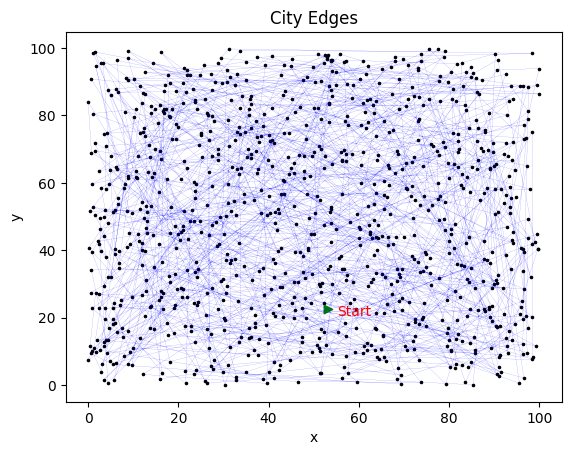



Generation: 118
Population Size: 5379	 Average Fitness: 34507.07
Best Fitness: 33850.42
Total Best Fitness :  33850.42
Total time :  119.49349427223206
Best Path: [0, 218, 400, 354, 673, 337, 651, 743, 639, 33, 962, 497, 386, 946, 828, 866, 2, 544, 132, 398, 293, 3, 451, 415, 101, 612, 518, 447, 641, 542, 510, 46, 680, 753, 516, 175, 763, 859, 294, 660, 978, 374, 261, 835, 299, 747, 996, 405, 173, 912, 502, 26, 454, 439, 392, 88, 943, 424, 237, 618, 933, 69, 857, 826, 194, 662, 169, 551, 956, 665, 168, 350, 156, 750, 300, 406, 844, 231, 39, 494, 251, 364, 769, 543, 373, 637, 174, 24, 286, 473, 771, 477, 422, 471, 947, 171, 697, 886, 812, 920, 858, 582, 931, 462, 83, 694, 196, 259, 678, 650, 534, 31, 71, 225, 417, 397, 924, 120, 819, 845, 590, 871, 677, 10, 915, 565, 149, 367, 76, 894, 609, 402, 49, 508, 621, 781, 938, 672, 141, 930, 349, 592, 656, 755, 202, 902, 853, 315, 381, 738, 148, 359, 560, 430, 94, 593, 683, 821, 809, 776, 765, 806, 578, 555, 407, 739, 267, 893, 486, 19, 700, 

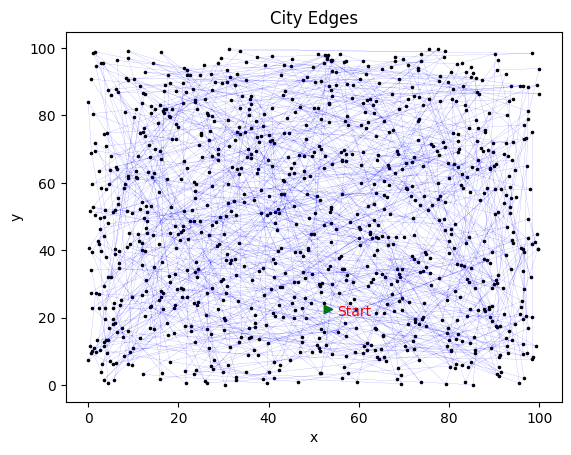



Generation: 250
Population Size: 18562	 Average Fitness: 34281.48
Best Fitness: 33399.89
Total Best Fitness :  33399.89
Total time :  249.10954308509827
Best Path: [0, 218, 400, 354, 673, 337, 651, 642, 64, 479, 363, 764, 368, 288, 361, 146, 198, 634, 383, 496, 517, 255, 492, 742, 743, 639, 33, 962, 946, 386, 497, 941, 522, 419, 691, 712, 215, 51, 490, 867, 901, 327, 243, 905, 801, 191, 318, 280, 47, 748, 426, 810, 954, 463, 796, 164, 415, 451, 3, 293, 398, 132, 544, 2, 866, 828, 773, 880, 984, 759, 195, 454, 324, 154, 291, 980, 875, 433, 372, 585, 841, 9, 298, 341, 326, 21, 342, 163, 384, 317, 482, 435, 448, 997, 699, 480, 145, 861, 283, 993, 851, 692, 362, 836, 181, 115, 108, 98, 189, 770, 85, 919, 351, 353, 40, 259, 678, 650, 534, 845, 590, 871, 592, 656, 394, 216, 958, 113, 348, 786, 732, 685, 860, 179, 884, 896, 528, 611, 974, 488, 144, 1, 420, 376, 664, 358, 730, 292, 162, 366, 985, 319, 563, 258, 716, 983, 406, 300, 750, 879, 6, 968, 445, 818, 797, 899, 597, 959, 927, 515, 579

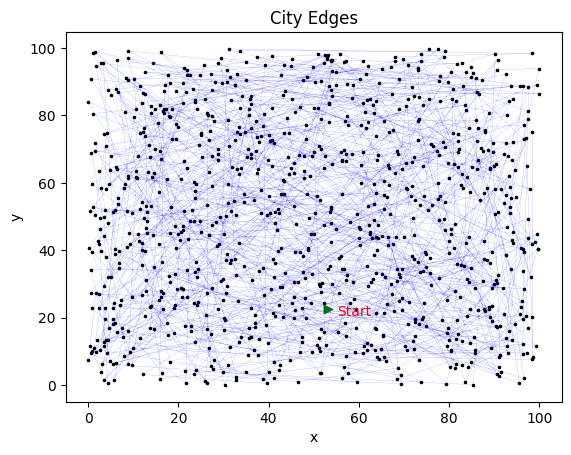



Generation: 452
Population Size: 38753	 Average Fitness: 34145.67
Best Fitness: 33136.91
Total Best Fitness :  33136.91
Total time :  444.53716564178467
Best Path: [0, 218, 400, 354, 673, 337, 651, 984, 759, 195, 531, 669, 877, 918, 751, 340, 464, 438, 839, 67, 412, 971, 20, 489, 246, 566, 615, 192, 479, 128, 954, 339, 209, 452, 197, 119, 645, 852, 951, 584, 491, 165, 125, 512, 59, 247, 989, 133, 804, 644, 113, 958, 216, 394, 656, 71, 31, 534, 40, 353, 351, 919, 899, 515, 217, 234, 115, 108, 98, 630, 200, 530, 613, 474, 653, 130, 558, 628, 223, 196, 694, 83, 462, 931, 87, 795, 603, 787, 849, 428, 114, 608, 874, 166, 274, 201, 263, 396, 654, 466, 25, 345, 134, 985, 366, 162, 292, 730, 358, 664, 376, 420, 1, 144, 488, 974, 611, 528, 896, 342, 163, 384, 317, 498, 820, 833, 215, 28, 107, 761, 135, 446, 925, 411, 453, 790, 772, 84, 365, 939, 633, 688, 975, 276, 140, 355, 577, 942, 890, 230, 142, 760, 581, 429, 527, 177, 290, 481, 666, 805, 316, 972, 331, 663, 719, 79, 704, 228, 91, 437, 7

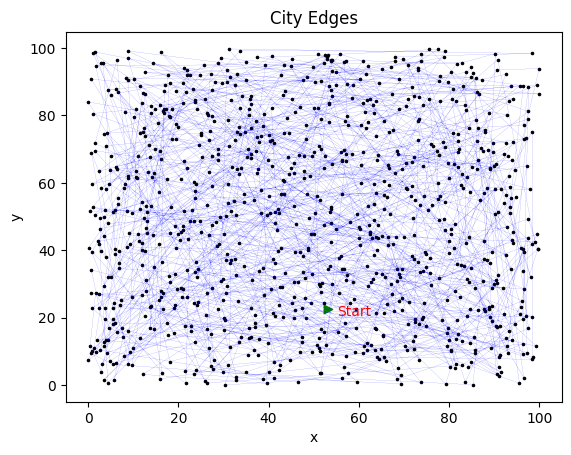



Generation: 721
Population Size: 65650	 Average Fitness: 34052.51
Best Fitness: 32960.73
Total Best Fitness :  32960.73
Total time :  706.7433109283447
Best Path: [0, 218, 400, 354, 673, 337, 651, 479, 363, 764, 368, 743, 639, 33, 962, 946, 386, 497, 941, 522, 419, 691, 712, 215, 490, 867, 901, 327, 243, 905, 801, 191, 318, 280, 47, 748, 426, 810, 954, 3, 293, 398, 132, 544, 2, 866, 828, 773, 880, 984, 759, 195, 454, 324, 154, 291, 980, 875, 433, 342, 163, 384, 317, 482, 435, 448, 642, 64, 362, 437, 91, 228, 704, 79, 719, 663, 331, 972, 316, 805, 666, 481, 290, 177, 527, 982, 605, 907, 640, 531, 669, 751, 340, 464, 438, 67, 119, 645, 852, 951, 584, 491, 165, 125, 512, 59, 247, 989, 133, 695, 310, 836, 181, 564, 698, 38, 126, 519, 846, 449, 18, 573, 599, 99, 896, 528, 611, 974, 488, 144, 1, 420, 376, 664, 358, 730, 292, 162, 366, 985, 84, 365, 939, 874, 630, 98, 108, 115, 217, 515, 927, 959, 597, 819, 845, 590, 871, 592, 656, 394, 216, 958, 113, 644, 804, 102, 116, 332, 82, 193, 633, 

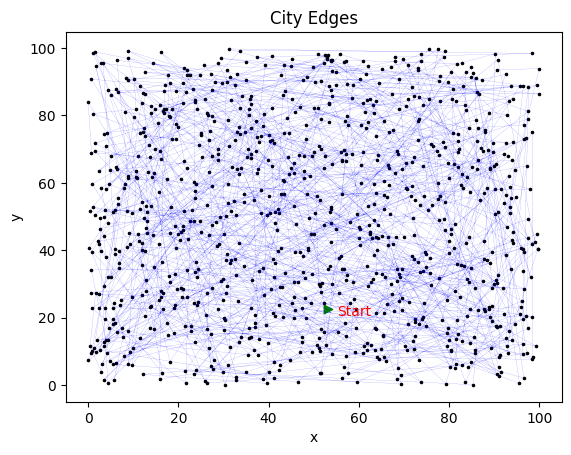



Generation: 830
Population Size: 76547	 Average Fitness: 34025.87
Best Fitness: 32883.62
Total Best Fitness :  32883.62
Total time :  819.3810720443726
Best Path: [0, 218, 400, 354, 673, 337, 651, 642, 64, 479, 764, 368, 941, 522, 419, 691, 712, 191, 318, 280, 47, 748, 426, 810, 954, 164, 415, 451, 3, 293, 398, 132, 544, 2, 866, 828, 454, 372, 585, 841, 9, 298, 341, 326, 21, 342, 163, 384, 317, 482, 836, 181, 115, 108, 98, 919, 351, 353, 40, 259, 678, 650, 534, 896, 899, 515, 877, 669, 531, 527, 177, 290, 481, 666, 805, 25, 686, 170, 166, 274, 201, 263, 396, 654, 466, 165, 491, 584, 951, 852, 645, 153, 811, 508, 621, 781, 938, 672, 141, 930, 349, 76, 894, 609, 402, 49, 275, 602, 937, 794, 932, 183, 313, 438, 464, 340, 751, 918, 562, 868, 813, 783, 689, 23, 119, 75, 952, 104, 329, 73, 239, 347, 110, 537, 549, 388, 717, 265, 864, 623, 72, 619, 948, 977, 39, 494, 251, 364, 769, 543, 373, 637, 174, 24, 286, 473, 277, 401, 221, 706, 677, 582, 858, 920, 812, 886, 697, 171, 947, 471, 422, 9

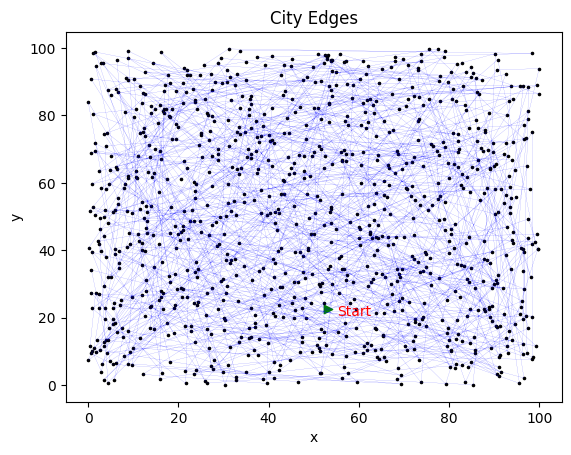



Generation: 933
Population Size: 86843	 Average Fitness: 34004.32
Best Fitness: 32802.43
Total Best Fitness :  32802.43
Total time :  926.4453160762787
Best Path: [0, 218, 400, 354, 673, 337, 651, 642, 64, 479, 764, 368, 941, 522, 419, 691, 712, 191, 318, 280, 47, 748, 426, 810, 954, 164, 415, 451, 3, 293, 398, 132, 544, 2, 866, 828, 454, 372, 585, 841, 9, 298, 341, 326, 21, 342, 163, 384, 317, 482, 836, 181, 98, 919, 351, 353, 40, 259, 678, 650, 534, 896, 899, 515, 877, 669, 531, 527, 177, 290, 481, 666, 805, 25, 166, 274, 201, 263, 396, 654, 466, 165, 491, 584, 951, 852, 645, 153, 811, 508, 621, 781, 938, 672, 141, 930, 349, 76, 894, 609, 402, 49, 275, 602, 937, 794, 932, 183, 313, 438, 464, 340, 751, 918, 562, 868, 813, 783, 689, 23, 119, 75, 952, 329, 73, 239, 347, 110, 537, 549, 388, 717, 265, 864, 623, 72, 619, 948, 977, 39, 494, 251, 364, 769, 543, 373, 637, 174, 24, 286, 473, 277, 401, 221, 706, 677, 582, 858, 920, 812, 886, 697, 171, 947, 471, 422, 970, 156, 41, 241, 227, 88

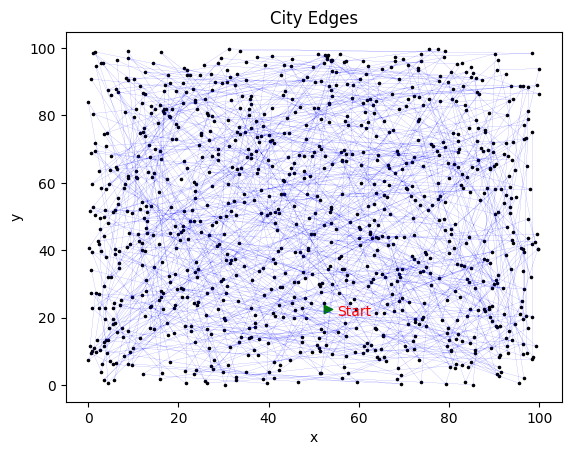



Generation: 955
Population Size: 89042	 Average Fitness: 34000.12
Best Fitness: 32726.54
Total Best Fitness :  32726.54
Total time :  960.736733675003
Best Path: [0, 218, 400, 354, 673, 337, 651, 518, 612, 101, 479, 564, 698, 38, 126, 519, 846, 449, 18, 573, 599, 99, 907, 640, 695, 102, 116, 991, 776, 765, 806, 578, 134, 345, 25, 156, 514, 431, 627, 74, 577, 23, 689, 916, 103, 788, 935, 554, 442, 777, 213, 782, 638, 208, 850, 955, 594, 583, 548, 952, 75, 585, 372, 430, 94, 683, 821, 809, 741, 249, 147, 837, 377, 306, 894, 671, 803, 381, 738, 148, 359, 560, 379, 541, 229, 279, 629, 105, 302, 236, 459, 408, 862, 703, 157, 718, 966, 832, 740, 802, 273, 906, 754, 752, 182, 68, 433, 13, 343, 957, 242, 136, 926, 967, 506, 255, 492, 742, 642, 64, 517, 496, 383, 634, 348, 786, 732, 685, 860, 179, 884, 896, 528, 611, 974, 488, 144, 1, 420, 376, 664, 358, 730, 292, 162, 366, 985, 988, 425, 503, 655, 779, 61, 301, 756, 552, 380, 631, 498, 820, 833, 54, 525, 50, 468, 122, 371, 37, 319, 709, 80, 

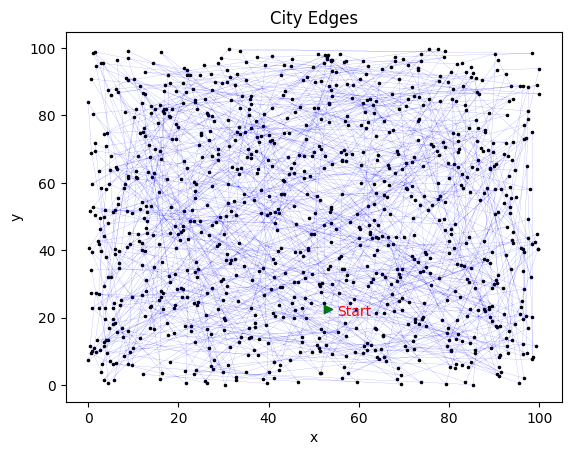



Generation: 1769
Population Size: 170433	 Average Fitness: 33891.98
Best Fitness: 32665.33
Total Best Fitness :  32665.33
Total time :  1764.104469537735
Best Path: [0, 218, 400, 354, 673, 337, 651, 743, 639, 33, 962, 542, 641, 447, 518, 612, 101, 415, 451, 3, 293, 946, 386, 497, 656, 394, 216, 958, 113, 393, 564, 698, 38, 126, 519, 846, 449, 18, 573, 599, 907, 640, 695, 102, 116, 332, 670, 778, 922, 118, 287, 382, 487, 335, 34, 909, 495, 222, 387, 17, 311, 635, 690, 865, 266, 814, 749, 785, 964, 728, 310, 280, 318, 191, 801, 905, 243, 327, 880, 773, 271, 715, 265, 217, 330, 921, 43, 127, 224, 515, 264, 129, 199, 187, 206, 41, 161, 644, 804, 133, 989, 247, 59, 512, 125, 165, 491, 584, 951, 852, 190, 159, 57, 483, 22, 211, 356, 42, 625, 281, 657, 63, 992, 297, 953, 702, 696, 205, 81, 78, 725, 24, 286, 473, 214, 268, 361, 288, 745, 571, 568, 272, 562, 868, 813, 783, 240, 720, 883, 95, 138, 478, 307, 941, 522, 419, 691, 712, 282, 155, 172, 735, 12, 410, 305, 998, 885, 395, 687, 173, 405

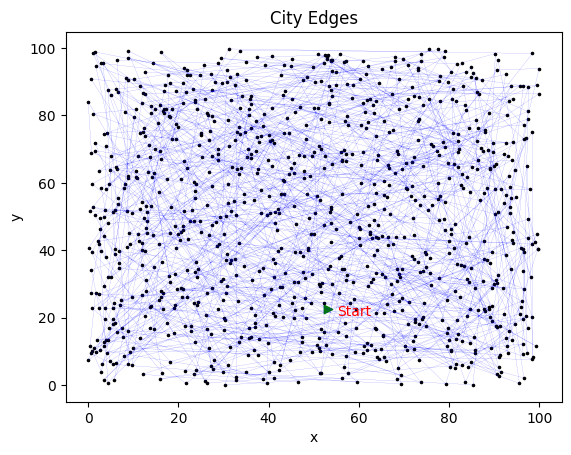



Generation: 2070
Population Size: 200528	 Average Fitness: 33866.09
Best Fitness: 32586.63
Total Best Fitness :  32586.63
Total time :  2074.660581111908
Best Path: [0, 218, 400, 743, 639, 33, 962, 786, 348, 389, 540, 58, 681, 722, 189, 707, 661, 789, 304, 100, 607, 609, 308, 827, 726, 992, 758, 961, 982, 898, 176, 121, 265, 418, 55, 904, 464, 438, 839, 67, 412, 971, 20, 489, 246, 566, 615, 192, 37, 371, 122, 468, 50, 525, 942, 890, 230, 54, 142, 760, 897, 567, 627, 311, 17, 487, 382, 287, 643, 178, 586, 581, 285, 965, 768, 32, 792, 204, 440, 970, 329, 239, 73, 96, 82, 193, 53, 994, 546, 854, 444, 399, 112, 887, 772, 84, 365, 939, 874, 845, 590, 871, 592, 538, 746, 70, 706, 221, 401, 431, 385, 188, 979, 934, 848, 737, 606, 458, 723, 667, 264, 129, 199, 187, 206, 41, 267, 739, 407, 555, 350, 168, 665, 956, 486, 360, 580, 391, 731, 856, 556, 111, 409, 77, 253, 840, 658, 323, 710, 729, 342, 163, 384, 317, 482, 435, 448, 997, 363, 764, 368, 16, 288, 361, 268, 214, 745, 571, 568, 272, 526

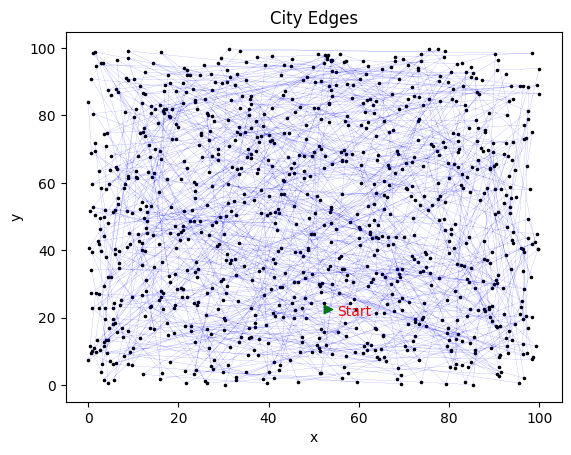



Generation: 2259
Population Size: 219426	 Average Fitness: 33851.53
Best Fitness: 32520.58
Total Best Fitness :  32520.58
Total time :  2277.2719388008118
Best Path: [0, 218, 400, 354, 673, 337, 651, 518, 564, 698, 38, 126, 519, 846, 449, 18, 573, 599, 99, 907, 640, 695, 102, 116, 991, 776, 765, 806, 578, 134, 345, 25, 23, 689, 916, 103, 788, 935, 554, 442, 777, 213, 782, 638, 208, 850, 955, 594, 583, 548, 952, 75, 809, 741, 249, 147, 837, 377, 306, 894, 379, 541, 229, 279, 629, 105, 302, 236, 459, 408, 862, 703, 157, 718, 966, 832, 740, 802, 273, 906, 754, 752, 182, 68, 348, 786, 732, 685, 860, 179, 884, 896, 528, 611, 974, 488, 144, 1, 420, 376, 664, 358, 730, 292, 162, 366, 985, 988, 425, 503, 655, 779, 61, 301, 756, 552, 380, 631, 80, 960, 416, 838, 533, 570, 65, 538, 746, 70, 706, 221, 401, 421, 526, 215, 28, 466, 654, 396, 263, 201, 274, 338, 936, 676, 587, 524, 520, 521, 422, 471, 947, 734, 48, 576, 51, 775, 636, 649, 344, 493, 873, 470, 62, 987, 403, 509, 453, 378, 180, 539, 

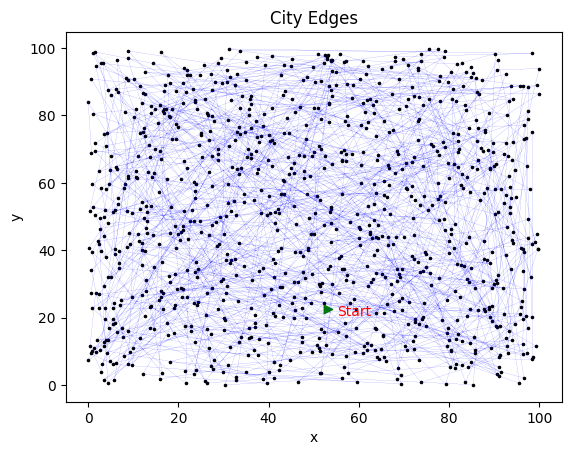



Generation: 2670
Population Size: 260521	 Average Fitness: 33823.6
Best Fitness: 32477.3
Total Best Fitness :  32477.3
Total time :  2704.9563529491425
Best Path: [0, 218, 400, 354, 673, 337, 651, 518, 612, 101, 479, 564, 698, 38, 126, 519, 846, 449, 18, 573, 599, 99, 991, 776, 765, 806, 578, 156, 627, 74, 23, 689, 916, 103, 788, 935, 554, 442, 777, 213, 782, 638, 208, 850, 955, 594, 583, 548, 952, 75, 585, 372, 94, 683, 821, 809, 741, 249, 147, 837, 894, 379, 541, 229, 279, 629, 236, 459, 408, 862, 703, 157, 718, 966, 832, 740, 802, 273, 906, 754, 752, 182, 68, 433, 255, 492, 742, 642, 64, 517, 496, 383, 634, 348, 786, 732, 685, 860, 179, 884, 896, 528, 611, 988, 425, 503, 655, 779, 61, 301, 756, 552, 380, 631, 498, 820, 833, 54, 525, 50, 468, 122, 371, 37, 319, 709, 80, 960, 416, 838, 533, 570, 65, 538, 746, 70, 706, 221, 401, 421, 526, 215, 28, 466, 654, 396, 263, 201, 274, 166, 772, 446, 925, 411, 790, 800, 363, 764, 409, 622, 111, 556, 856, 731, 391, 580, 360, 207, 950, 908, 432

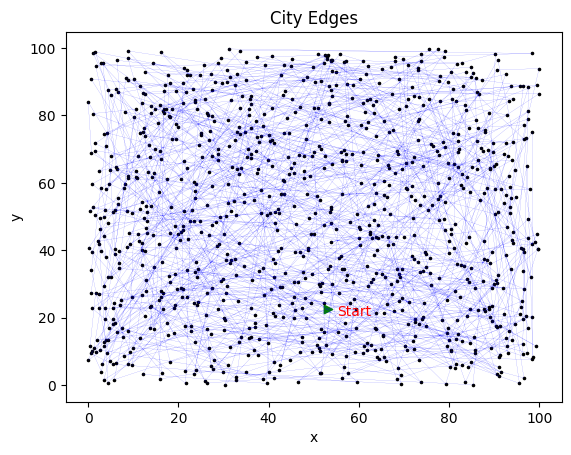



Generation: 2887
Population Size: 282219	 Average Fitness: 33810.68
Best Fitness: 32403.76
Total Best Fitness :  32403.76
Total time :  2942.1524481773376
Best Path: [0, 218, 400, 354, 673, 337, 651, 518, 612, 101, 479, 564, 698, 38, 126, 519, 846, 449, 18, 573, 599, 99, 991, 776, 765, 806, 578, 156, 627, 74, 23, 689, 916, 103, 788, 935, 554, 442, 777, 213, 782, 638, 208, 850, 955, 594, 583, 548, 952, 75, 585, 372, 94, 683, 821, 809, 741, 249, 147, 837, 894, 379, 541, 229, 279, 629, 408, 862, 703, 157, 718, 966, 832, 740, 802, 273, 906, 754, 752, 182, 68, 433, 255, 492, 742, 642, 64, 517, 496, 383, 634, 348, 786, 732, 685, 860, 179, 884, 896, 528, 611, 988, 425, 503, 655, 779, 61, 301, 756, 552, 380, 631, 498, 820, 833, 54, 525, 50, 468, 122, 371, 37, 319, 709, 80, 960, 416, 538, 746, 70, 706, 221, 401, 421, 526, 215, 28, 466, 654, 396, 263, 201, 274, 166, 20, 971, 412, 67, 839, 438, 464, 340, 751, 918, 888, 981, 296, 328, 593, 970, 96, 73, 239, 994, 53, 104, 999, 29, 882, 262, 325, 

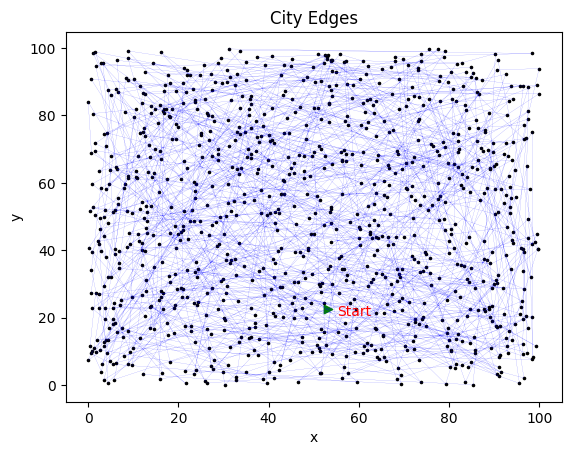



Generation: 2952
Population Size: 288719	 Average Fitness: 33806.84
Best Fitness: 32388.19
Total Best Fitness :  32388.19
Total time :  3022.096179485321
Best Path: [0, 218, 400, 354, 673, 337, 651, 743, 639, 33, 962, 447, 168, 350, 278, 744, 774, 799, 889, 601, 595, 308, 827, 726, 45, 160, 203, 616, 255, 988, 425, 503, 362, 942, 637, 174, 277, 401, 221, 706, 70, 746, 538, 592, 871, 590, 845, 40, 353, 351, 919, 899, 597, 959, 927, 515, 217, 32, 792, 204, 440, 923, 233, 782, 213, 777, 442, 546, 854, 444, 399, 112, 887, 239, 73, 96, 422, 471, 947, 655, 779, 61, 301, 756, 552, 144, 488, 974, 611, 528, 896, 794, 932, 183, 505, 334, 501, 727, 633, 688, 793, 870, 150, 499, 190, 159, 57, 483, 22, 211, 356, 42, 625, 281, 657, 63, 741, 823, 421, 526, 272, 568, 571, 745, 214, 268, 361, 119, 540, 58, 681, 722, 829, 725, 78, 81, 205, 696, 702, 953, 297, 992, 647, 304, 275, 602, 937, 313, 270, 208, 850, 193, 82, 156, 348, 707, 661, 789, 387, 222, 495, 909, 34, 335, 382, 287, 679, 798, 607, 100, 9

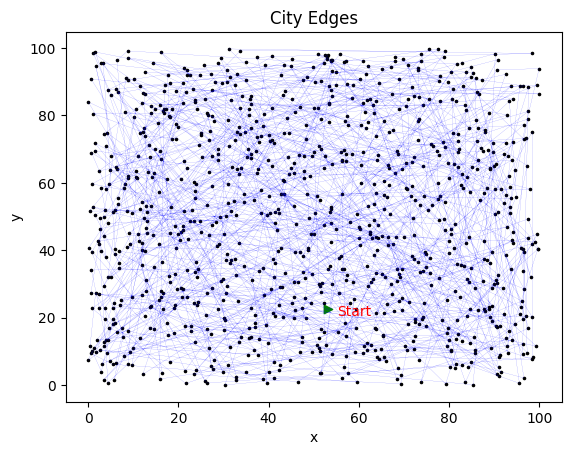



Generation: 4459
Population Size: 439410	 Average Fitness: 33740.55
Best Fitness: 32319.59
Total Best Fitness :  32319.59
Total time :  4663.945817232132
Best Path: [0, 218, 400, 354, 673, 337, 651, 743, 639, 33, 962, 217, 121, 176, 898, 982, 605, 936, 676, 587, 734, 48, 518, 656, 394, 216, 958, 113, 393, 479, 907, 640, 695, 102, 116, 332, 670, 778, 922, 118, 635, 690, 865, 266, 415, 451, 3, 293, 398, 132, 544, 2, 866, 828, 90, 456, 878, 320, 876, 347, 563, 258, 716, 983, 967, 506, 324, 490, 702, 696, 24, 286, 473, 745, 571, 568, 272, 95, 138, 478, 174, 637, 373, 543, 769, 364, 251, 494, 39, 977, 948, 619, 72, 623, 110, 537, 549, 47, 748, 426, 810, 508, 621, 781, 938, 171, 697, 128, 954, 976, 970, 256, 269, 500, 255, 492, 742, 988, 425, 503, 655, 779, 61, 301, 756, 552, 380, 498, 820, 833, 230, 890, 942, 525, 50, 863, 421, 526, 469, 429, 667, 124, 808, 723, 458, 606, 737, 201, 274, 805, 666, 481, 290, 177, 527, 531, 669, 688, 633, 617, 184, 306, 377, 687, 395, 885, 998, 305, 410, 12,

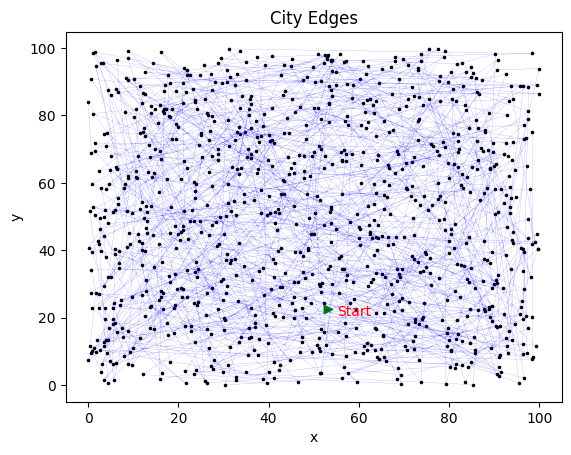



Generation: 5308
Population Size: 524307	 Average Fitness: 33713.32
Best Fitness: 32294.03
Total Best Fitness :  32294.03
Total time :  5643.39116859436
Best Path: [0, 218, 400, 354, 673, 337, 651, 743, 639, 33, 962, 313, 183, 932, 794, 937, 602, 275, 764, 363, 553, 940, 931, 87, 795, 603, 787, 849, 428, 114, 608, 166, 274, 985, 366, 162, 292, 730, 358, 664, 376, 420, 1, 144, 488, 974, 611, 528, 896, 108, 98, 944, 476, 801, 905, 243, 327, 265, 877, 330, 921, 43, 127, 224, 45, 160, 203, 616, 579, 951, 852, 645, 805, 258, 24, 288, 497, 649, 344, 687, 395, 885, 998, 305, 410, 12, 735, 172, 800, 379, 541, 229, 475, 559, 460, 485, 314, 321, 551, 956, 665, 168, 350, 486, 444, 792, 32, 99, 599, 573, 18, 449, 846, 519, 126, 38, 698, 564, 181, 836, 854, 546, 994, 53, 916, 103, 788, 935, 554, 442, 777, 213, 782, 233, 923, 440, 204, 49, 402, 609, 894, 76, 367, 149, 565, 915, 677, 582, 858, 920, 812, 886, 697, 171, 346, 270, 600, 791, 991, 591, 891, 52, 572, 423, 532, 295, 89, 86, 279, 629, 105,

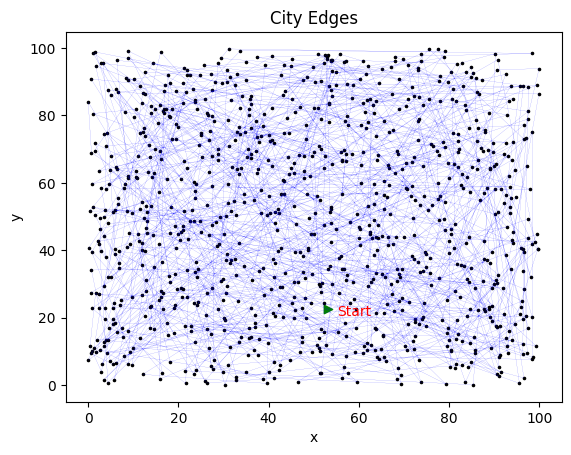



Generation: 8031
Population Size: 796595	 Average Fitness: 33649.61
Best Fitness: 32288.34
Total Best Fitness :  32288.34
Total time :  8996.260240793228
Best Path: [0, 218, 400, 354, 673, 337, 651, 743, 639, 33, 962, 313, 183, 932, 794, 937, 602, 275, 764, 363, 553, 940, 931, 87, 795, 603, 787, 849, 428, 114, 608, 166, 274, 985, 366, 162, 292, 730, 358, 664, 376, 420, 1, 144, 488, 974, 611, 528, 896, 944, 476, 265, 877, 203, 616, 579, 951, 852, 645, 805, 258, 24, 288, 497, 649, 344, 687, 395, 885, 998, 305, 410, 12, 735, 172, 800, 379, 541, 229, 475, 559, 460, 485, 314, 321, 551, 956, 665, 168, 350, 486, 444, 792, 32, 99, 599, 573, 18, 449, 846, 519, 126, 38, 698, 564, 854, 546, 994, 53, 916, 103, 788, 935, 554, 442, 777, 213, 782, 233, 923, 440, 204, 49, 402, 609, 894, 76, 367, 149, 565, 915, 677, 582, 858, 920, 812, 886, 697, 171, 346, 991, 591, 891, 52, 572, 423, 532, 295, 89, 86, 279, 629, 105, 302, 822, 768, 965, 285, 328, 816, 892, 969, 910, 97, 567, 897, 643, 178, 586, 581, 7

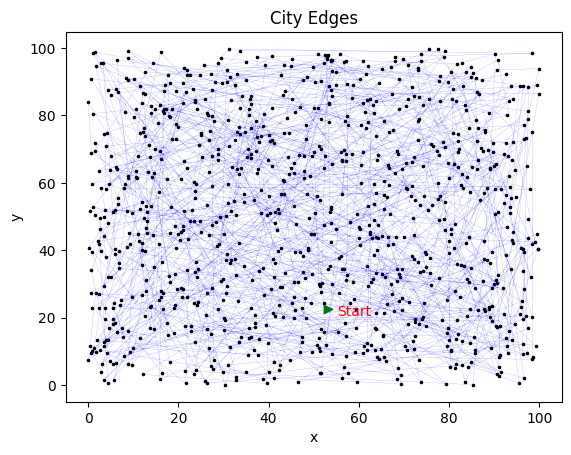



Generation: 8270
Population Size: 820493	 Average Fitness: 33645.14
Best Fitness: 32269.37
Total Best Fitness :  32269.37
Total time :  9317.937199115753
Best Path: [0, 218, 400, 354, 673, 337, 651, 803, 671, 441, 434, 232, 238, 523, 504, 440, 204, 792, 32, 49, 402, 609, 831, 11, 139, 914, 455, 724, 843, 484, 27, 521, 520, 524, 562, 868, 225, 417, 397, 924, 120, 376, 664, 358, 730, 292, 162, 366, 985, 684, 189, 983, 716, 258, 563, 743, 639, 33, 962, 946, 386, 497, 164, 630, 98, 927, 972, 535, 825, 614, 427, 646, 338, 895, 949, 539, 576, 493, 873, 470, 198, 463, 796, 362, 692, 851, 993, 132, 398, 293, 8, 15, 574, 10, 915, 565, 149, 367, 76, 71, 31, 515, 217, 234, 115, 108, 200, 530, 613, 474, 653, 130, 558, 628, 223, 196, 694, 83, 462, 931, 87, 795, 603, 787, 849, 428, 114, 608, 166, 274, 466, 25, 345, 134, 610, 5, 588, 301, 61, 779, 655, 503, 425, 988, 161, 156, 170, 277, 945, 158, 686, 195, 759, 923, 421, 119, 681, 722, 829, 725, 219, 325, 304, 100, 607, 798, 679, 313, 229, 375, 991

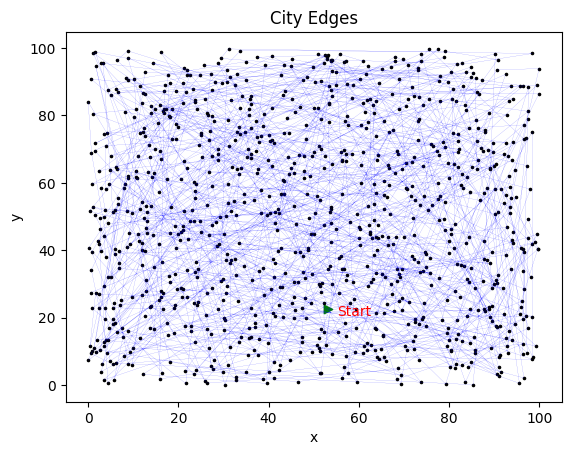



Generation: 8848
Population Size: 878288	 Average Fitness: 33635.16
Best Fitness: 32158.92
Total Best Fitness :  32158.92
Total time :  10087.275837659836
Best Path: [0, 218, 400, 354, 673, 337, 651, 753, 680, 518, 612, 101, 479, 287, 382, 487, 335, 34, 909, 495, 222, 867, 490, 7, 265, 250, 659, 4, 278, 744, 774, 799, 889, 601, 595, 308, 827, 726, 84, 365, 939, 165, 970, 340, 912, 978, 660, 860, 179, 884, 896, 300, 750, 797, 899, 597, 959, 927, 579, 616, 877, 290, 481, 666, 805, 448, 997, 845, 508, 621, 781, 938, 672, 141, 930, 349, 156, 976, 14, 545, 226, 303, 482, 435, 42, 625, 684, 564, 698, 38, 126, 519, 846, 449, 18, 252, 516, 175, 763, 859, 294, 741, 727, 501, 334, 505, 562, 868, 813, 275, 96, 329, 374, 261, 835, 299, 747, 996, 405, 173, 229, 541, 298, 341, 326, 21, 923, 233, 782, 444, 454, 849, 428, 399, 112, 123, 626, 477, 771, 844, 829, 164, 362, 692, 851, 993, 283, 861, 145, 480, 699, 592, 871, 635, 690, 916, 103, 788, 935, 992, 758, 961, 963, 878, 456, 90, 590, 942, 525, 5

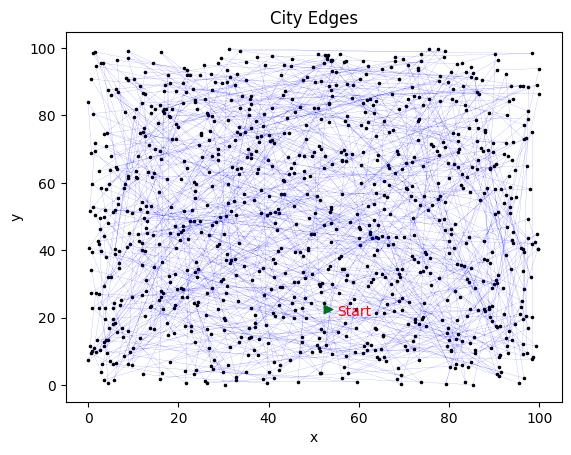



Generation: 10068
Population Size: 1000282	 Average Fitness: 33615.91
Best Fitness: 32097.22
Total Best Fitness :  32097.22
Total time :  11756.891354084015
Best Path: [0, 218, 400, 743, 639, 33, 962, 946, 386, 497, 34, 909, 495, 222, 311, 635, 690, 865, 880, 773, 217, 330, 921, 43, 127, 224, 515, 21, 326, 341, 312, 506, 967, 926, 136, 981, 888, 459, 236, 174, 637, 373, 543, 517, 496, 383, 759, 195, 927, 959, 597, 722, 684, 562, 868, 240, 720, 883, 95, 138, 478, 691, 712, 155, 687, 173, 405, 996, 747, 299, 835, 261, 374, 196, 694, 83, 462, 931, 87, 795, 603, 787, 849, 428, 114, 608, 939, 365, 84, 385, 188, 979, 934, 848, 245, 30, 557, 536, 117, 817, 842, 248, 701, 432, 908, 950, 207, 19, 360, 580, 391, 731, 856, 556, 111, 622, 409, 794, 932, 183, 997, 448, 435, 317, 384, 163, 135, 761, 107, 28, 215, 526, 421, 401, 221, 706, 70, 746, 538, 346, 416, 960, 80, 793, 437, 91, 228, 704, 79, 719, 663, 830, 913, 596, 414, 675, 322, 469, 429, 755, 202, 902, 853, 315, 807, 219, 260, 620, 911, 5

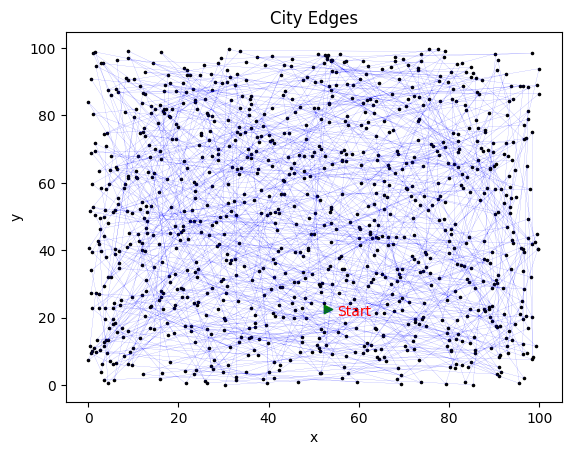

In [ ]:
solution=GeneticAlgorithm(populationSize=100, Generation_Count=1000000) #Population size, Generation Count 입력